# Hierarchical Models

In [1]:
import collections
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyjags
import scipy.stats as sstats

import plot_utils

In [2]:
%load_ext autoreload

%autoreload 2

# Exercise 1

Therapoetic touch data with different priors

## Question A + B

Compare vague gamma distributed priors with different parameters.

In [3]:
# Calculations are based on info from wikipedia
# http://en.wikipedia.org/wiki/Gamma_distribution

GammaParams = collections.namedtuple('GammaParams', ['shape', 'scale'])


def gamma_params_from_mean_and_sd(mean, sd):
    return GammaParams((mean / sd) ** 2, sd ** 2 / mean)


def gamma_params_from_mode_and_sd(mode, sd):
    scale = ((mode ** 2 + 4 * sd ** 2) ** 0.5 - mode) / 2
    shape = (sd / scale) ** 2
    return GammaParams(shape, scale)

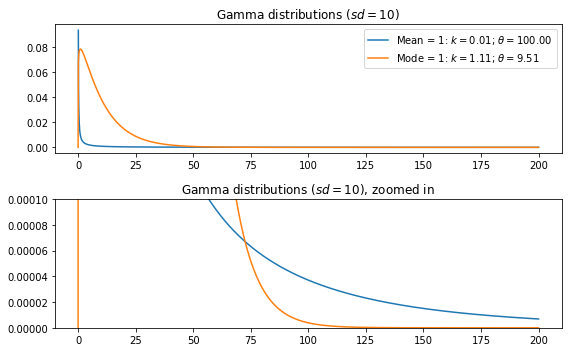

In [4]:
def plot_gammas(x, *gamma_params_list, legend_prefixes=(), ax=None):
    if ax is None:
        ax = plt.gca()

    for gamma_params, prefix in itertools.zip_longest(gamma_params_list, legend_prefixes):
        text = r'$k = {shape:.2f}$; $\theta = {scale:.2f}$'.format_map(gamma_params._asdict())
        if prefix:
            text = f'{prefix}: {text}'
        ax.plot(x, sstats.gamma(gamma_params.shape, scale=gamma_params.scale).pdf(x), label=text)
        
    return ax


gammas = [
    gamma_params_from_mean_and_sd(1, 10),
    gamma_params_from_mode_and_sd(1, 10),
]

_, axes = plt.subplots(nrows=2, figsize=(8, 5))

x = np.linspace(0, 200, 2000)

ax = axes[0]
plot_gammas(x, *gammas, legend_prefixes=('Mean = 1', 'Mode = 1'), ax=ax)
title = 'Gamma distributions $(sd = 10)$'
ax.legend()
ax.set(title=title)

ax = axes[1]
plot_gammas(x, *gammas, ax=ax)
ax.set(ylim=(0, .0001), title=title + ', zoomed in')

plt.tight_layout()

The gamma distribution with mode = 1 favors values between 0.1 and 75.

The gamma distribution with mean = 1 favors very small values or those larger than 75.

## Question C

Notice how the different priors generate similar posteriors.

In [5]:
df = pd.read_csv('data/therapeutic_touch_data.csv')

In [6]:
code = """
model {
    for (s in 1:Nsubj) {
        z[s] ~ dbin(theta[s], N[s])
        theta[s] ~ dbeta(omega * (kappa - 2) + 1, (1 - omega) * (kappa - 2) + 1)
    }
    omega ~ dbeta(1, 1)
    kappa <- kappaMinusTwo + 2
    kappaMinusTwo ~ dgamma(shape, 1 / scale)
}
"""

data = {
    'Nsubj': len(df['s'].unique()),
    'N': df.groupby('s')['y'].count().values,
    'z': df.groupby('s')['y'].sum().values,
}

In [7]:
def run_model_with_gamma_params(code, data, params):
    data['shape'] = params.shape
    data['scale'] = params.scale
    model = pyjags.Model(code=code, data=data, chains=4)
    return model.sample(
        vars=['theta', 'omega', 'kappa'],
        iterations=40_000,  # Aiming for >10k effective sample size on higher level params
    )

Mean of 1 and standard deviation of 10.

In [8]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_model_with_gamma_params(code, data, gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 96020 of 160000, elapsed 0:00:08, remaining 0:00:05
sampling: iterations 154328 of 160000, elapsed 0:00:13, remaining 0:00:00
sampling: iterations 160000 of 160000, elapsed 0:00:14, remaining 0:00:00


[Text(0.5, 0, '$\\kappa$')]

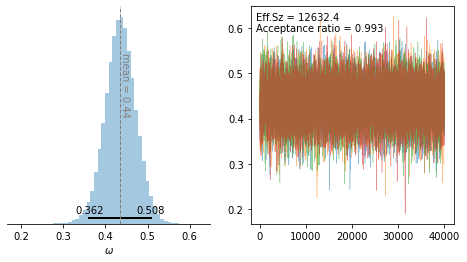

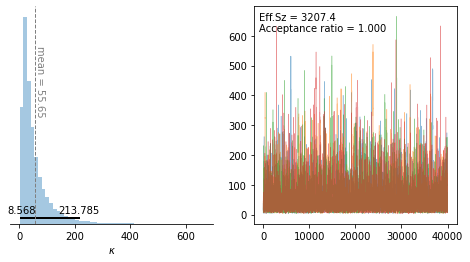

In [9]:
axes = plot_utils.trace(trace['omega'][0])
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace['kappa'][0])
axes[0].set(xlabel=r'$\kappa$')

Mode of 1 and standard deviation of 10.

In [10]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
trace = run_model_with_gamma_params(code, data, gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 76836 of 160000, elapsed 0:00:09, remaining 0:00:10
sampling: iterations 119352 of 160000, elapsed 0:00:15, remaining 0:00:05
sampling: iterations 160000 of 160000, elapsed 0:00:20, remaining 0:00:00


[Text(0.5, 0, '$\\kappa$')]

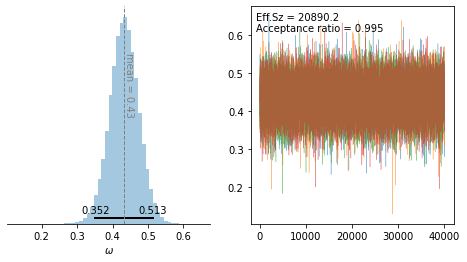

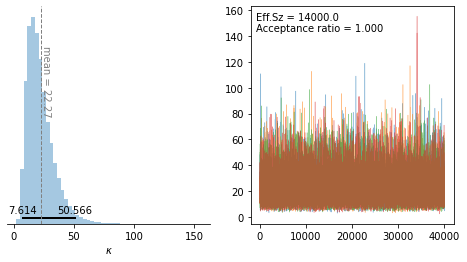

In [11]:
axes = plot_utils.trace(trace['omega'][0])
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace['kappa'][0])
axes[0].set(xlabel=r'$\kappa$')

## Question D

The posterior for $\kappa$ changed by changing the prior from `mean=1, sd=10` to `mode=1, sd=10`. First of all, the effective sample size grew significantly. With 160,000 samples, the ESS when `mean=1` is ~3k, while with `mode=1` it's ~14k (refering to the `pyjags` trace here).

Question: "For which prior does the marginal posterior distribution on $\kappa$ have a bigger large-value tail?"

For the `mean=1` prior $\kappa$ has a bigger large-value tail.

Question: "When $\kappa$ is larger, what effect does that have on shrinkage of the thetas values?"

When $\kappa$ is larger the subjects' $\theta$s are expected to shift closer to the higher level parameter $\omega$, resulting in more shrinkage.

## Question E

See next exercise.

# Exercise 2

Examine the priors implied on lower level parameters with `mean=1` vs. `mode=1` for higher level parameter.

In [12]:
prior_data = data.copy()
del prior_data['z']

Mean of 1 and standard deviation of 10.

In [13]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_model_with_gamma_params(code=code, data=prior_data, params=gamma_params)

sampling: iterations 160000 of 160000, elapsed 0:00:01, remaining 0:00:00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61ed345c70>,
      dtype=object)

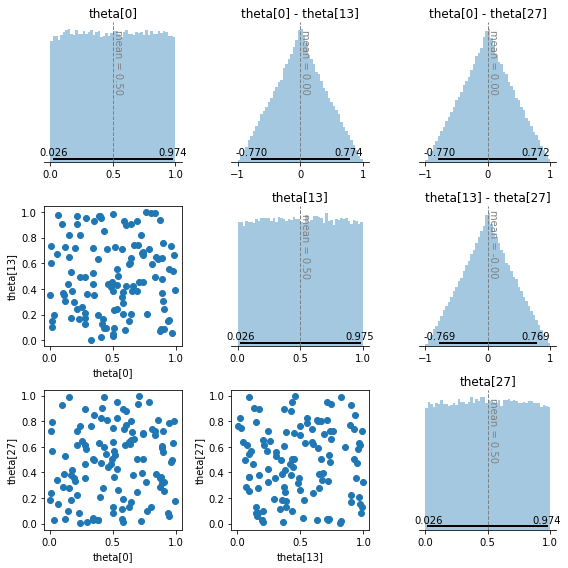

In [14]:
plot_utils.param_comparison(trace, 'theta', [0, 13, 27])

Mode of 1 and standard deviation of 10.

In [15]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
trace = run_model_with_gamma_params(code=code, data=prior_data, params=gamma_params)

sampling: iterations 160000 of 160000, elapsed 0:00:01, remaining 0:00:00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61ef323fa0>,
      dtype=object)

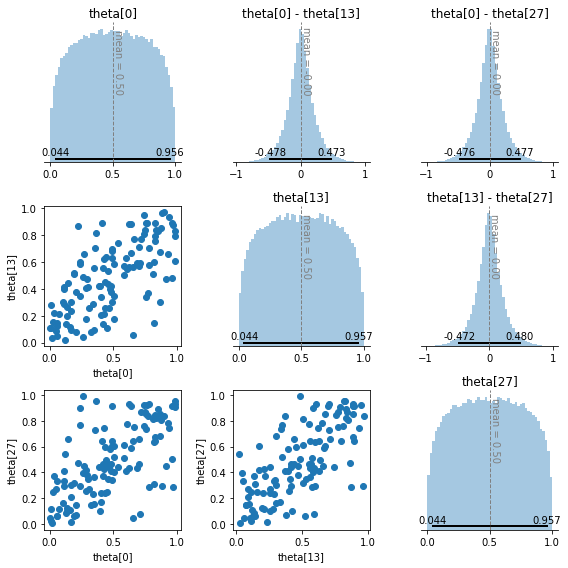

In [16]:
plot_utils.param_comparison(trace, 'theta', [0, 13, 27])

## Question A

With `mode=1` the lower level parameters are rounded. This is because $\kappa$ can be large, constraining the lower level parameters to stay close to the higher level $\omega$ parameter.

## Question B

If we are fine with having a bias towards chance performance, having `mean=1` is fine. If we want not to have bias for individuals it's better to use `mode=1`.

# Exercise 3

In [17]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_model_with_gamma_params(code=code, data=data, params=gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 102900 of 160000, elapsed 0:00:08, remaining 0:00:05
sampling: iterations 160000 of 160000, elapsed 0:00:13, remaining 0:00:00
sampling: iterations 160000 of 160000, elapsed 0:00:13, remaining 0:00:00


In [18]:
percentage_correct = df.groupby('s')['y'].mean()
estimates = [theta.mean() for theta in trace['theta']]

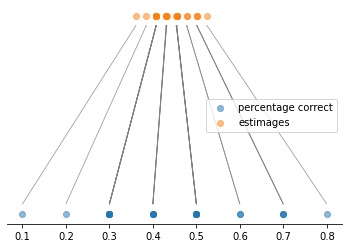

In [19]:
plot_utils.shrinkage(percentage_correct, estimates)

Bayesian analysis provides priors, with specific beliefes about the data and underlying parameters. Shrinkage is affecte by both the priors and the data. With MLE, shrinkage is only affected by the data (and the model structure of course).